<a href="https://colab.research.google.com/github/bvm84/Samsung-dishes/blob/master/Dishes_tf2_mobilenet_datasets_kaggle_subs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
!pip install keras-tuner
import tensorflow as tf
from IPython.display import clear_output
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
import os
import pathlib
import random
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import matplotlib.pyplot as plt
from pathlib import PurePath
from pandas import DataFrame
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, Normalizer
from sklearn.model_selection import cross_val_score, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from kerastuner.tuners import Hyperband
from kerastuner.tuners import RandomSearch
!unzip -o /content/drive/My\ Drive/Colab/Dishes/platesv3.zip -d /content
clear_output()
print('Unzip done')

Unzip done


In [0]:
# Settings
% matplotlib inline
tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
Augment = False

In [0]:
data_dir = pathlib.Path('/content/plates')
clean = tf.data.Dataset.list_files(str(data_dir/'train/cleaned/*'), shuffle=True)
dirty = tf.data.Dataset.list_files(str(data_dir/'train/dirty/*'), shuffle=True)
test = tf.data.Dataset.list_files(str(data_dir/'test/*'), shuffle=True)
clean_value = len(list(clean))
dirty_value = len(list(dirty))
if clean_value == dirty_value and clean_value % 5 ==0:
    train = clean.take(int(4*clean_value/5)).concatenate(dirty.take(int(4*clean_value/5)))
    validate = clean.skip(int(4*clean_value/5)).concatenate(dirty.skip(int(4*clean_value/5)))
else:
    raise Exception('Wrong clean and dirty dimensions')
CLASS_NAMES = np.array([item.name for item in data_dir.joinpath('train').glob('*')])

In [0]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, '/')
    # The second to last is the class-directory
    return 0 if parts[-2] == CLASS_NAMES[0] else 1
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [0]:
train_ds = train.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = validate.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [0]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    # Repeat forever
    ds = ds.repeat()
    ds = ds.batch(batch_size=BATCH_SIZE, drop_remainder=False)
    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds
def prepare_for_val_test(ds, cache=True, shuffle_buffer_size=400):
    ds = ds.batch(batch_size=BATCH_SIZE, drop_remainder=False)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

In [0]:
def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

def color(x: tf.Tensor) -> tf.Tensor:
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

def rotate(x: tf.Tensor) -> tf.Tensor:
    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

def zoom(x: tf.Tensor) -> tf.Tensor:
    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(32, 32))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

In [143]:
# augmentations = [flip, color, zoom, rotate]
augmentations = [flip, color, rotate]
train_ds_opt = prepare_for_training(train_ds)
val_ds_opt = prepare_for_val_test(val_ds)
test_ds_opt = prepare_for_val_test(test_ds)
# apply augmentation
if Augment is True:
    for f in augmentations:
        train_ds_opt = train_ds_opt.map(lambda x, y: tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: (f(x), y), lambda: (x, y)), \
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_ds_opt = train_ds_opt.map(lambda x, y: (tf.clip_by_value(x, 0, 1), y))
    STEPS_PER_EPOCH = STEPS_PER_EPOCH * 10
# print(train_ds.numpy())
print(train_ds_opt.take(1))
image_batch, label_batch = next(iter(train_ds_opt))
val_image_batch, val_label_batch = next(iter(val_ds_opt))
for image_batch, label_batch in train_ds.batch(BATCH_SIZE).take(1):
   pass

print(image_batch.shape)
'''
labels_arr = np.empty(shape=[0, 2], dtype=np.bool)
for _, labels in train_ds.take(STEPS_PER_EPOCH):
    # print(type(labels.numpy()[0]))
    labels_arr = np.append(labels_arr, labels.numpy(), axis=0)
print(labels_arr)
print(len(labels_arr))
'''

<TakeDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int32)>
(32, 224, 224, 3)


'\nlabels_arr = np.empty(shape=[0, 2], dtype=np.bool)\nfor _, labels in train_ds.take(STEPS_PER_EPOCH):\n    # print(type(labels.numpy()[0]))\n    labels_arr = np.append(labels_arr, labels.numpy(), axis=0)\nprint(labels_arr)\nprint(len(labels_arr))\n'

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
32


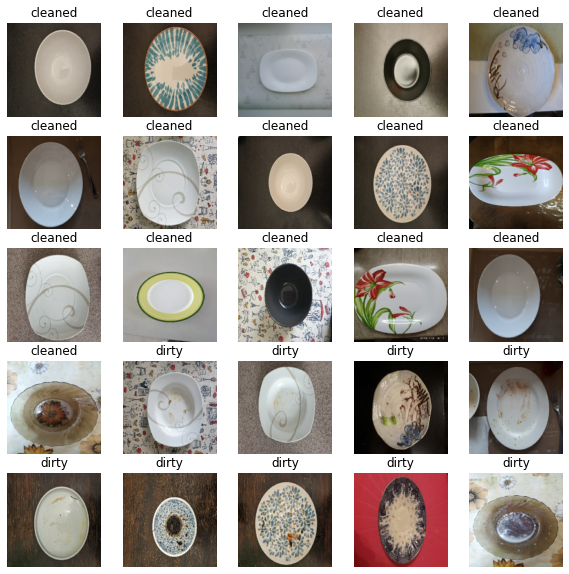

In [144]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[label_batch[n]])
        plt.axis('off')
show_batch(image_batch.numpy(), label_batch.numpy())
print(label_batch.numpy())
print(len(label_batch.numpy()))

In [0]:
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [146]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [147]:
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              # loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [149]:
initial_epochs = 10
validation_steps = 20

loss0, accuracy0 = model.evaluate(val_ds_opt, steps = 1, batch_size = 8)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

1/1 [==============================] - 0s 8ms/step - loss: 0.6589 - accuracy: 0.6250
initial loss: 0.66
initial accuracy: 0.62


In [150]:
history = model.fit(train_ds_opt,
                    batch_size = BATCH_SIZE,
                    epochs=initial_epochs,
                    steps_per_epoch=10,
                    validation_data=val_ds_opt,
                    validation_steps=1,
                    validation_batch_size=8)

Epoch 1/10
10/10 [==============================] - 10s 978ms/step - loss: 0.9196 - accuracy: 0.5000 - val_loss: 0.7543 - val_accuracy: 0.5000
Epoch 2/10
10/10 [==============================] - 10s 985ms/step - loss: 0.7897 - accuracy: 0.5063 - val_loss: 0.7126 - val_accuracy: 0.6250
Epoch 3/10
10/10 [==============================] - 10s 976ms/step - loss: 0.7194 - accuracy: 0.5531 - val_loss: 0.7579 - val_accuracy: 0.6250
Epoch 4/10
10/10 [==============================] - 10s 974ms/step - loss: 0.6695 - accuracy: 0.6156 - val_loss: 0.5969 - val_accuracy: 0.6250
Epoch 5/10
10/10 [==============================] - 10s 976ms/step - loss: 0.6289 - accuracy: 0.6094 - val_loss: 0.6168 - val_accuracy: 0.7500
Epoch 6/10
10/10 [==============================] - 10s 976ms/step - loss: 0.5927 - accuracy: 0.6438 - val_loss: 0.7901 - val_accuracy: 0.2500
Epoch 7/10
10/10 [==============================] - 10s 981ms/step - loss: 0.5588 - accuracy: 0.6719 - val_loss: 0.5586 - val_accuracy: 0.7500

In [151]:
loss0, accuracy0 = model.evaluate(val_ds_opt, steps = 1, batch_size = 8)
print("After training loss: {:.2f}".format(loss0))
print("After training accuracy: {:.2f}".format(accuracy0))
predictions = model.predict(test_ds_opt)
print(predictions)

1/1 [==============================] - 0s 7ms/step - loss: 0.5551 - accuracy: 0.6250
After training loss: 0.56
After training accuracy: 0.62
[[0.4897984 ]
 [0.2436254 ]
 [0.21675196]
 [0.33209157]
 [0.56084484]
 [0.2030791 ]
 [0.30434102]
 [0.3162266 ]
 [0.30011475]
 [0.3374995 ]
 [0.4255609 ]
 [0.34894013]
 [0.6206524 ]
 [0.2541752 ]
 [0.31072438]
 [0.52569294]
 [0.44304892]
 [0.4935311 ]
 [0.599786  ]
 [0.6827887 ]
 [0.21415266]
 [0.41809607]
 [0.27473247]
 [0.5048403 ]
 [0.6137761 ]
 [0.24416998]
 [0.55835557]
 [0.3706242 ]
 [0.15932506]
 [0.2821739 ]
 [0.51510185]
 [0.50576985]
 [0.37399924]
 [0.59002405]
 [0.4635894 ]
 [0.786077  ]
 [0.63749164]
 [0.31360078]
 [0.5856106 ]
 [0.37081122]
 [0.43579492]
 [0.5710124 ]
 [0.16596562]
 [0.37960276]
 [0.68212384]
 [0.38247007]
 [0.6675029 ]
 [0.40942174]
 [0.28648937]
 [0.25097978]
 [0.42550552]
 [0.2843015 ]
 [0.548069  ]
 [0.7342274 ]
 [0.46361232]
 [0.5947171 ]
 [0.24998924]
 [0.4435912 ]
 [0.26887885]
 [0.4816956 ]
 [0.501907  ]
 [0.2

In [193]:
print(len(predictions))
d = {'id': [n for n in range(len(predictions))], 
     'label': ['dirty' if x > 0.5 else 'cleaned' for x in predictions]}
result_df = DataFrame(data=d)
print(result_df['label'].value_counts())
result_df.to_csv('sub.csv', index=False)

744
cleaned    539
dirty      205
Name: label, dtype: int64


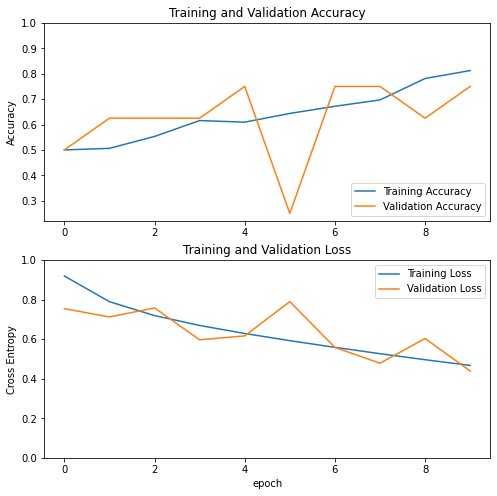

In [153]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [175]:
pip install --upgrade kaggle

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [194]:

# !mkdir .kaggle
#!ls -a
# !cp /content/drive/My\ Drive/Colab/kaggle.json ~/.kaggle/kaggle.json
#!kaggle config view
# !kaggle datasets list
!kaggle competitions submit -c platesv2 -f sub.csv -m "MobileNet Colab first try"

100% 8.22k/8.22k [00:00<00:00, 31.8kB/s]
Successfully submitted to Cleaned vs Dirty V2

# New Section